# 02. Life Distribution Analysis

이 노트북에서는 각 엔진(unit)의 수명(`time`)을 기반으로 잔존 수명(RUL)을 정의하고,
그 분포를 시각화하여 예측 타깃의 구조를 이해합니다.

In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# 데이터 로드
# 컬럼명 정의 (NASA 문서 기반)
column_names = [
    'unit', 'time', 'op1', 'op2', 'op3',
    's1', 's2', 's3', 's4', 's5',
    's6', 's7', 's8', 's9', 's10',
    's11', 's12', 's13', 's14', 's15',
    's16', 's17', 's18', 's19', 's20',
    's21'
]
df = pd.read_csv('../data/CMaps/train_FD001.txt', sep='\s+', header=None, names=column_names)
print("컬럼 개수:", df.shape[1])

컬럼 개수: 26


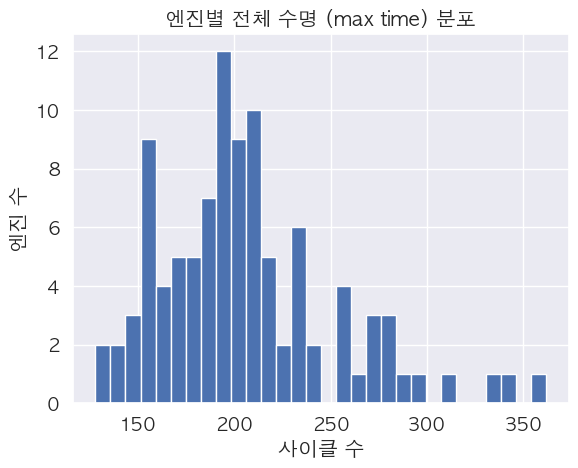

In [44]:
# unit별 최대 수명 확인 (고장 직전)
rul_max = df.groupby('unit')['time'].max()
rul_max.hist(bins=30)
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False
plt.title('엔진별 전체 수명 (max time) 분포')
plt.xlabel('사이클 수')
plt.ylabel('엔진 수')
plt.show()

####  엔진별 수명 분포 (train_FD001.txt 기준)

- 대부분의 엔진은 150~250 사이클 사이에서 고장 발생  
- 일부는 300~350 이상까지 버티지만, 극소수  
→ 비정상적으로 긴 수명은 아웃라이어로 볼 수도 있음  

In [46]:
drop_cols = ['op3', 's1', 's10', 's18', 's19']
df_selected = df.drop(columns=drop_cols)

In [47]:
df_selected.head()

,unit,time,op1,op2,s2,s3,s4,s5,s6,s7,...,s9,s11,s12,s13,s14,s15,s16,s17,s20,s21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,14.62,21.61,554.36,...,9046.19,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,14.62,21.61,553.75,...,9044.07,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,14.62,21.61,554.26,...,9052.94,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,14.62,21.61,554.45,...,9049.48,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,14.62,21.61,554.00,...,9055.15,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,38.90,23.4044


In [48]:
# 잔존 수명(RUL) 계산: RUL = max(time) - time
df_selected['RUL'] = df.groupby('unit')['time'].transform(lambda x: x.max() - x)
df_selected[['unit', 'time', 'RUL']].head()

,unit,time,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


train_FD001.txt에서 생성한 unit, time, RUL 컬럼이 잘 들어갔다.  
→ 각 엔진의 첫 번째 row는 가장 초기에 측정된 상태이며, 그 시점의 잔존 수명이 RUL  
→ 시간이 지날수록 RUL은 1씩 줄고, 마지막 row는 RUL = 0  

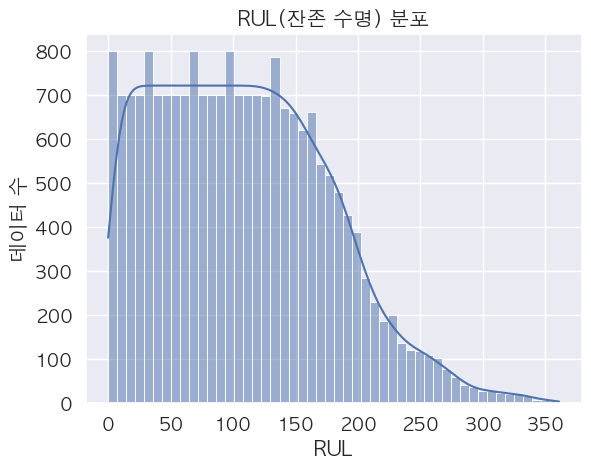

In [49]:
# 전처리데이터 RUL 분포 시각화
sns.histplot(df_selected['RUL'], bins=50, kde=True)
plt.title('RUL(잔존 수명) 분포')
plt.xlabel('RUL')
plt.ylabel('데이터 수')
plt.show()

- 0~125 사이 구간: 데이터가 균등하게 분포
- 125 이후: 데이터 수가 급격히 감소 → 희귀
- 200 이상: 거의 없음 (드문 outlier 수준)

실무적 판단: RUL 클리핑 필요

머신러닝 회귀 문제에서 너무 긴 RUL은  
- 예측 오차에 영향만 크게 주고  
- 실제 정비/보전 관점에서도 의미 없음  